# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#import gensim
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [4]:
# files will be present in "/content/drive/My Drive".
#!ls "/content/drive/My Drive/MachineLearning"


In [5]:
# using the SQLite Table to read data.
#con = sqlite3.connect('/content/drive/My Drive/MachineLearning/database.sqlite') 

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:27<00:00, 3205.75it/s]


In [23]:
final['Cleaned Text'] = preprocessed_reviews

In [24]:
sample1 = pd.DataFrame()

In [25]:
sample1['Cleaned Text'] =preprocessed_reviews

In [26]:
sample1.tail(3)

,Cleaned Text
87770,trader joe product good quality buy straight t...
87771,coffee supposedly premium tastes watery thin n...
87772,purchased product local store ny kids love qui...


In [27]:
k1 = []

In [28]:
sample1.shape

(87773, 1)

In [29]:
for i in range(0,87773):
    k1.append(len(preprocessed_reviews[i]))

In [30]:
sample1['Length'] = k1

In [31]:
sample1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Splitting the Data with feature engineering

In [33]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(sample1,final['Score'].values,test_size=0.3,shuffle=False)

In [34]:
y_train1.shape

(61441,)

In [38]:
X_train1.shape

(61441, 2)

In [39]:
X_test1.shape

(26332, 2)

In [40]:
type(y_test1)

numpy.ndarray

In [41]:
type(X_test1)

pandas.core.frame.DataFrame

In [35]:
X_train1.head(3)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406


In [36]:
X_test1.head(3)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181


In [37]:
X_trainbow = pd.DataFrame()

In [38]:
X_trainbow['Cleaned Text'] = X_train1['Cleaned Text'] 

In [39]:
X_trainbow.head(3)

,Cleaned Text
0,dogs loves chicken product china wont buying a...
1,dogs love saw pet store tag attached regarding...
2,infestation fruitflies literally everywhere fl...


In [40]:
X_testbow = pd.DataFrame()

In [41]:
X_testbow['Cleaned Text'] = X_test1['Cleaned Text']

In [42]:
X_testbow.head(3)

,Cleaned Text
61441,used treat training reward dog loves easy brea...
61442,much fun watching puppies asking chicken treat...
61443,little shih tzu absolutely loves cesar softies...


# BAG OF WORDS WITH FEATURE ENGINEERING 

In [43]:
X_trainbow.shape

(61441, 1)

In [44]:
X_testbow.shape

(26332, 1)

In [45]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b1 = count_vect.transform(X_testbow['Cleaned Text'])

In [46]:
print("the type of count vectorizer :",type(a1))
print("the shape of out text BOW vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (61441, 46008)
the number of unique words : 46008


# ADDING LENGTH OF REVIEWS AS ONE FEATURE 

In [47]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [48]:
a1 = preprocessing.normalize(a1)
a2 = sparse.csr_matrix(X_train1['Length'].values)
a2 = preprocessing.normalize(a2)
a3 = sparse.hstack([a1, a2.T])

In [49]:
b1 = preprocessing.normalize(b1)
b2 = sparse.csr_matrix(X_test1['Length'].values)
b2 = preprocessing.normalize(b2)
b3 = sparse.hstack([b1, b2.T])

In [57]:
y_test1.shape

(26332,)

In [58]:
y_train1.shape

(61441,)

# SVM FOR BOW with Feature Engineering

In [55]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [54]:
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier

# Applying Linear SVM FOR bow 

In [56]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SGDClassifier(loss='hinge',class_weight = 'balanced')
param_grid = {'alpha':alpha}
model_bow = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 10, return_train_score = True)
model_bow.fit(a3, y_train1)
print(model_bow.best_estimator_)
print(model_bow.score(b3, y_test1))

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.9454290671371609


# Observations:
1) We found that the optimal alpha = 0.0001 in Linear SVM and the AUC value is quite good.

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

# Running the Model with Optimal HYPER PARAMETERS

In [51]:
from sklearn.metrics import roc_auc_score

In [57]:
train_auc1= model_bow.cv_results_['mean_train_score']
cv_auc1= model_bow.cv_results_['mean_test_score']

In [58]:
train_auc1

array([0.97320285, 0.95855441, 0.91970162, 0.81935988, 0.78292612,
       0.78292612, 0.78292612, 0.78292612, 0.78292612, 0.78292612,
       0.78292612])

In [59]:
cv_auc1

array([0.93924168, 0.94059129, 0.91008351, 0.81475138, 0.77966889,
       0.77966889, 0.77966889, 0.77966889, 0.77966889, 0.77966889,
       0.77966889])

In [60]:
import math
from math import log

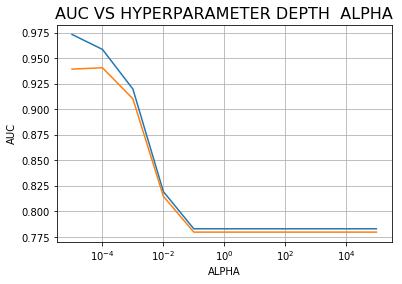



 Alpha Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each alpha value is :
  [0.9732  0.95855 0.9197  0.81936 0.78293 0.78293 0.78293 0.78293 0.78293
 0.78293 0.78293]

 CV AUC for each alpha value is :
  [0.93924 0.94059 0.91008 0.81475 0.77967 0.77967 0.77967 0.77967 0.77967
 0.77967 0.77967]


In [61]:
# Firstly I am plotting depth vs AUC and then split vs AUC
plt.plot(alpha,train_auc1)
plt.plot(alpha,cv_auc1)
plt.xlabel('ALPHA',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER DEPTH  ALPHA',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha Values :\n", alpha)
print("\n Train AUC for each alpha value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each alpha value is :\n ", np.round(cv_auc1,5))

In [62]:
max(cv_auc1)

0.9405912899256196

# Observations

1) We have found that the hyperparmeter ALPHA should be 0.0001 for having maximum AUC for CV 


In [0]:
# after you found the best hyper parameter, you need to train your model with it, 
#and find the AUC on test data and plot the ROC curve on both train and test. 
# Along with plotting ROC curve, you need to print the confusion matrix with predicted 
#and original labels of test data points. Please visualize your confusion matrices using seaborn heatmaps. 

# Training the model with the best hyper parameter 

In [63]:
om_bow = SGDClassifier(alpha=0.0001,class_weight = 'balanced') # Hinge loss is not used as probabilities I cannot get
om_bow = CalibratedClassifierCV(om_bow, cv= 5)

In [64]:
om_bow.fit(a3, y_train1)
ompredictions_bow  = om_bow.predict(b3)

In [0]:
# Probability Estimates are not there WHILE using hinge loss.

In [65]:
len(ompredictions_bow)

26332

In [66]:
probs = om_bow.predict_proba(b3)
probs1 = om_bow.predict_proba(a3)
probs = probs[:, 1]
probs1 = probs1[:, -1]

# FEATURE IMPORTANCE  FOR BOW 

In [0]:
# Again rerunning the model as I have to get feature importance

In [69]:
om_bowp = SGDClassifier(alpha=0.0001,class_weight = 'balanced')

In [70]:
om_bowp.fit(a3,y_train1)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [71]:
om_bowp.get_params

<bound method BaseEstimator.get_params of SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)>

In [72]:
count_vect.get_params

<bound method BaseEstimator.get_params of CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [73]:
features = count_vect.get_feature_names()

In [74]:
Coefficients = om_bowp.coef_

In [75]:
coef = Coefficients.reshape(46009,1)

In [76]:
coef.shape

(46009, 1)

In [77]:
coef = coef.tolist()

In [78]:
type(coef)

list

In [79]:
len(features)
features.append('zzzzzzzzzza')

In [80]:
len(features)

46009

In [0]:
#features=np.argsort(features)[::-1]

In [81]:
cf = pd.DataFrame({'Word' : features, 'Coefficient' : coef})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****')
print('\n')
print(cf_new.head(10))
print('\n')
print('***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****')
print('\n')
print(cf_new.tail(10))

***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****


            Word           Coefficient
10560  delicious   [4.455001909719882]
29622    perfect  [3.8362270713735867]
17569      great  [3.6708005160405612]
45177  wonderful   [3.561329279820464]
3744        best   [3.510946432908001]
13900  excellent  [3.4869254640950733]
23609      loves  [3.4791122711873963]
18895     highly   [3.174874780925968]
2762     awesome   [3.015127073025514]
1285     amazing  [3.0004170470635234]


***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****


                Word            Coefficient
38261          stale   [-2.662562682757956]
44424           weak  [-2.6853881669492004]
4105           bland  [-2.7377598318256386]
2768           awful  [-2.7519643992238314]
19249       horrible   [-2.757109149631728]
42813  unfortunately  [-3.1966425693619382]
40533       terrible   [-3.219130869703495]
11442  disappointing  [-3.7843594999913077]
45296          worst  [-3.9309858991070734]
11440   dis

# Observations :
1) We have found that not  and great are the top 2 words are delicious and amazing that is impacting positive class.

2) Disappointing and the wrost are the top two words that are impacting the negative class the most.

# PERFORMANCE MEASURMENTS  FOR BOW (LINEAR SVM)

In [82]:
precision_bow = precision_score(y_test1, ompredictions_bow, pos_label = 1) 
recall_bow = recall_score(y_test1, ompredictions_bow, pos_label = 1) 
f1score_bow = f1_score(y_test1, ompredictions_bow, pos_label = 1) 

In [83]:
print('\nThe Test Precision for optimal alpha for Linear SVM (BOW)   is %f' % (precision_bow))
print('\nThe Test Recall for optimal alpha for Linear SVM (BOW)  is %f' % (recall_bow))
print('\nThe Test F1-Score for optimal alpha for Linear SVM (BOW)  is %f' %  (f1score_bow))


The Test Precision for optimal alpha for Linear SVM (BOW)   is 0.933265

The Test Recall for optimal alpha for Linear SVM (BOW)  is 0.959503

The Test F1-Score for optimal alpha for Linear SVM (BOW)  is 0.946202


# CONFUSION MATRIX 

In [0]:
# Reference Links 
# https://datatofish.com/confusion-matrix-python/

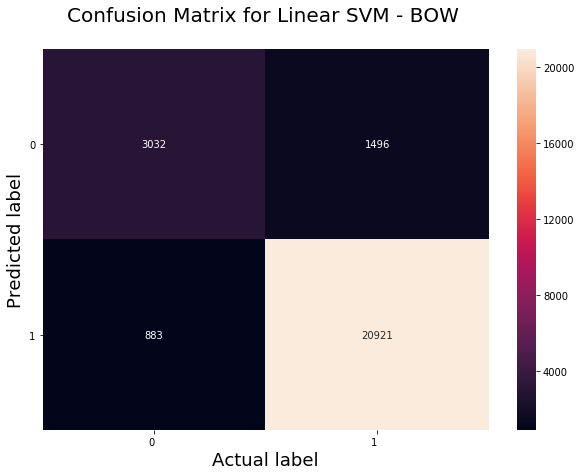

In [84]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_bow), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix for Linear SVM - BOW \n",size=20)
plt.show()

In [85]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_bow).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)

In [86]:
print("TPR of the Linear SVM  (BOW)   is :  %f" % (TPR))
print("FPR of the Linear SVM  (BOW)   is :  %f" % (FPR))
print("TNR of the Linear SVM (BOW)   is :  %f" % (TNR))
print("FNR of the Linear SVM  (BOW)  is :  %f" % (FNR))

TPR of the Linear SVM  (BOW)   is :  0.933265
FPR of the Linear SVM  (BOW)   is :  0.225543
TNR of the Linear SVM (BOW)   is :  0.774457
FNR of the Linear SVM  (BOW)  is :  0.066735


# PLOTTING THE ROC CURVE  (BOW) ---- > FOR BOTH TRAIN AND TEST DATA 

In [91]:
len(y_train1)

61441

In [0]:
len(probs1)

61441

In [87]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

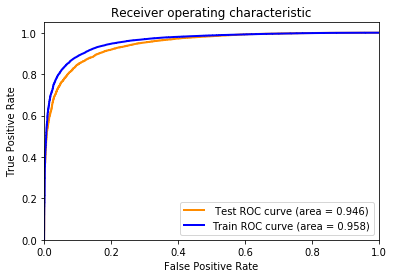

In [88]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 
1) We observe that AUC for train data is 0.98 and the test data is 0.95 which implies that the model is reasonably good. 

# TFIDF WITH FEATURE ENGINEERING 

In [89]:
tf_idf_vect = TfidfVectorizer(min_df=10)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (61441, 9723)
the number of unique words : 9723


In [90]:
c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['Length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])

In [91]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['Length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

# Linear SVM - TFIDF 

In [92]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SGDClassifier(loss='hinge',class_weight = 'balanced')
param_grid = {'alpha':alpha}
model_tfidf = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 10, return_train_score = True, verbose = 3)
model_tfidf.fit(c3, y_train1)
print(model_tfidf.best_estimator_)
print(model_tfidf.score(d3, y_test1))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9259875344649139, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.946969905938819, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.949816646858211, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9367014257458628, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9460335531995994, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] .............. alpha=1e-05, score=0.94110311971323, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9409478493757673, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9314015248907755, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9382002773791871, total=   0.1s
[CV] a

[CV] ................. alpha=1, score=0.883764511874671, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8929465907269245, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ................ alpha=10, score=0.900120209941646, total=   0.2s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8956644067837265, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8922831042462236, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8974631508073158, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8886361521769361, total=   0.1s
[CV] alpha=10 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   25.3s finished


SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.949641092534647


# Observations :

1) We found that the accuracy has enhanced when we used  all features . However computation time is more in this case.

# OPTIMAL ALPHA FOR TFIDF - THROUGH PLOTTING APPROACH 

In [93]:
train_auc_tfidf = model_tfidf.cv_results_['mean_train_score']
cv_auc_tfidf = model_tfidf.cv_results_['mean_test_score']

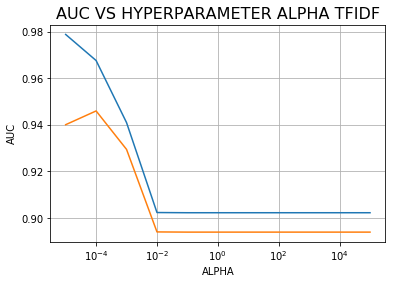



 Alpha Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each  value is :
  [0.97879 0.96759 0.94096 0.90236 0.90228 0.90228 0.90228 0.90228 0.90228
 0.90228 0.90228]

 CV AUC for each value is :
  [0.94006 0.94596 0.92946 0.89405 0.89396 0.89396 0.89396 0.89396 0.89396
 0.89396 0.89396]


In [94]:
plt.plot(alpha,train_auc_tfidf)
plt.plot(alpha,cv_auc_tfidf)
plt.xlabel('ALPHA',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER ALPHA TFIDF',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha Values :\n", alpha)
print("\n Train AUC for each  value is :\n ", np.round(train_auc_tfidf,5))
print("\n CV AUC for each value is :\n ", np.round(cv_auc_tfidf,5))

# Observations :

1) We found that optimal value is 0.0001

# Training the model with the best hyper parameter for TFIDF 

In [95]:
om_tfidf = SGDClassifier(alpha=0.0001,class_weight = 'balanced') # Hinge loss is not used as probabilities I cannot get
om_tfidf = CalibratedClassifierCV(om_tfidf, cv= 5)

In [96]:
om_tfidf.fit(c3, y_train1)
ompredictions_tfidf  = om_tfidf.predict(d3)

In [97]:
probs2 = om_tfidf.predict_proba(c3)
probs3 = om_tfidf.predict_proba(d3)
probs2= probs2[:, 1]
probs3 = probs3[:, 1]

# Feature  Importance for TFIDF  (Linear SVM)

In [98]:
features_tfidf = tf_idf_vect.get_feature_names()

In [99]:
om_tfidfp = SGDClassifier(alpha=0.0001,class_weight = 'balanced') 
om_tfidfp.fit(c3,y_train1)

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [100]:
len(features_tfidf)

9723

In [101]:
features_tfidf.append('zzzzzzzzzzzzzzaaaaa')

In [102]:
Coefficients.shape

(1, 46009)

In [103]:
Coefficients = om_tfidfp.coef_
coef = Coefficients.reshape(9724,1)
coef = coef.tolist()

In [104]:
len(coef)

9724

In [105]:
type(coef)

list

In [106]:
len(features_tfidf), len(coef)

(9724, 9724)

In [107]:
cf = pd.DataFrame({'Word' : features_tfidf, 'Coefficient' : coef})
cf_new = cf.sort_values("Coefficient", ascending = False)
print('***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****')
print('\n')
print(cf_new.head(10))
print('\n')
print('***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****')
print('\n')
print(cf_new.tail(10))

***** Top 10 IMPORTANT FEATURES FOR POSITIVE CLASS *****


           Word           Coefficient
3778      great  [5.8071582586193236]
2241  delicious   [4.836676910317802]
718        best   [4.539143206102038]
6176    perfect  [3.9417924070464587]
5008      loves  [3.8759689183827053]
2965  excellent   [3.566372697565489]
5003       love   [3.559462216077335]
9582  wonderful  [3.5026127258542696]
3698       good  [3.4185499916891304]
4045     highly   [3.197489635663025]


***** Top 10 IMPORTANT FEATURES FOR NEGATIVE CLASS *****


                Word            Coefficient
2445  disappointment    [-2.58302096914942]
4116        horrible  [-2.6292981922236174]
8750         thought  [-2.6786562790627775]
788            bland    [-2.74841129339232]
9129   unfortunately   [-2.895517148378411]
8676        terrible  [-3.1642052667590126]
2444   disappointing   [-3.635976736334212]
9616           worst  [-3.7296610933116394]
2443    disappointed   [-3.869217530365912]
5710             not  

# Observations :
1) We found that the top 2 most important features affecting positive class are great and delicious.

2) Top 2 most important features affecting negative class are not and disappointed

# PERFORMANCE MEASURMENTS FOR TFIDF 

In [108]:
precision_tfidf = precision_score(y_test1, ompredictions_tfidf, pos_label = 1) 
recall_tfidf = recall_score(y_test1, ompredictions_tfidf, pos_label = 1) 
f1score_tfidf = f1_score(y_test1, ompredictions_tfidf, pos_label = 1) 

In [109]:
print('\nThe Test Precision for optimal alpha for linear SVM  (TFIDF) is %f' % (precision_tfidf))
print('\nThe Test Recall for optimal alpha for linear SVM (TFIDF) is  %f' % (recall_tfidf))
print('\nThe Test F1-Score for optimal alpha for linear SVM(TFIDF) is  %f' % (f1score_tfidf))


The Test Precision for optimal alpha for linear SVM  (TFIDF) is 0.936856

The Test Recall for optimal alpha for linear SVM (TFIDF) is  0.959457

The Test F1-Score for optimal alpha for linear SVM(TFIDF) is  0.948022


# CONFUSION MATRIX (TFIDF)

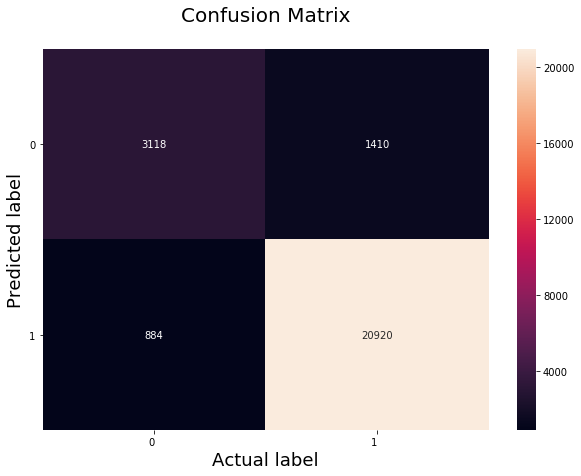

In [110]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_tfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()

In [111]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_tfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Linear SVM  (TFIDF) for alpha  is :  %f" % (TPR))
print("FPR of the  Linear SVM  (TFIDF) for alpha  is :  %f" % (FPR))
print("TNR of the  Linear SVM  (TFIDF) for alpha  is :  %f" % (TNR))
print("FNR of the  Linear SVM  (TFIDF) for alpha  is :  %f" % (FNR))

TPR of the Linear SVM  (TFIDF) for alpha  is :  0.936856
FPR of the  Linear SVM  (TFIDF) for alpha  is :  0.220890
TNR of the  Linear SVM  (TFIDF) for alpha  is :  0.779110
FNR of the  Linear SVM  (TFIDF) for alpha  is :  0.063144


# ROC CURVE FOR TFIDF 

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs3)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [113]:
from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    

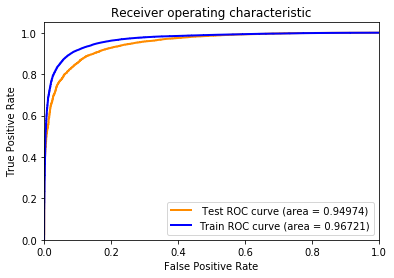

In [114]:
#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.5f)' % roc_auc[0])
plt.plot(fpr1[2], tpr1[2], color='blue',lw=lw, label='Train ROC curve (area = %0.5f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations: 
1) We found that the training score and the test score has been good. Hence the model is reasonably good

# Word 2 Vector Data

# Preparaing Training Data for Word to Vector 

In [115]:
i=0
list_of_sentance=[]
for sentance in (X_trainbow['Cleaned Text'].values):
    list_of_sentance.append(sentance.split())

In [116]:
#WORD TO VECTOR

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('awesome', 0.8387141227722168), ('fantastic', 0.825539231300354), ('terrific', 0.80866539478302), ('good', 0.806596040725708), ('wonderful', 0.7872923612594604), ('amazing', 0.7825056314468384), ('excellent', 0.7768963575363159), ('perfect', 0.7595521211624146), ('fabulous', 0.6763899922370911), ('decent', 0.6671922206878662)]
[('best', 0.723889172077179), ('tastiest', 0.7033755779266357), ('greatest', 0.6945815086364746), ('disgusting', 0.6411334872245789), ('awful', 0.6349409818649292), ('coolest', 0.6270347237586975), ('closest', 0.6220861673355103), ('sweetest', 0.6094496846199036), ('smoothest', 0.6014837026596069), ('experienced', 0.6008162498474121)]
number of words that occured minimum 5 times  14706
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding

In [117]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 61441/61441 [01:46<00:00, 576.72it/s]


61441
50


In [118]:
sent_vectors[1]

array([-0.12912887, -0.76420906, -0.15761923,  0.40769311, -0.72918309,
        0.07135952, -0.16411569, -0.16107504, -0.59605415, -0.79738394,
       -0.26945326, -0.83281161,  0.17938109, -0.30916784, -0.33834869,
       -0.45378742,  0.5442509 ,  0.33933452,  0.48258768, -0.43977127,
       -0.25969976,  0.2234058 ,  0.84654541,  0.90660261,  0.47916459,
        0.74423378,  0.47660786, -0.3766901 ,  0.79599934, -0.10644283,
       -0.23197277, -0.16741426, -0.06251451, -0.635977  ,  0.52959876,
       -1.38729947, -0.60243387,  0.50411926,  0.39830671,  0.61259393,
        0.60565934,  0.22240643,  0.80609812,  0.08869576,  0.73663351,
       -0.26700896, -1.11758449,  0.61151643,  0.25568527, -0.36326609])

# Preparing Test Data for Word to Vector 

In [0]:
X_test1.head(4)

,Cleaned Text,Length
61441,used treat training reward dog loves easy brea...,66
61442,much fun watching puppies asking chicken treat...,134
61443,little shih tzu absolutely loves cesar softies...,181
61444,westie like picture package loves treats perfe...,162


In [119]:
i=0
list_of_sentance1=[]
for sentance in (X_test1['Cleaned Text'].values):
    list_of_sentance1.append(sentance.split())

In [120]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model1=Word2Vec(list_of_sentance1,min_count=5,size=50, workers=4)
    print(w2v_model1.wv.most_similar('great'))
    print('='*50)
    print(w2v_model1.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model1.wv.most_similar('great'))
        print(w2v_model1.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

[('awesome', 0.848763108253479), ('excellent', 0.7997280955314636), ('fantastic', 0.7893553972244263), ('good', 0.783993124961853), ('wonderful', 0.7780619263648987), ('amazing', 0.7077950239181519), ('perfect', 0.6931569576263428), ('nice', 0.6887220740318298), ('decent', 0.684121310710907), ('delicious', 0.6560591459274292)]
[('best', 0.757299542427063), ('greatest', 0.7377722263336182), ('ever', 0.7260575294494629), ('closest', 0.7169400453567505), ('nastiest', 0.7163026332855225), ('hottest', 0.7093741297721863), ('horrible', 0.6963449716567993), ('superior', 0.6925037503242493), ('disgusting', 0.6703665256500244), ('carob', 0.6548367738723755)]
number of words that occured minimum 5 times  9573
sample words  ['used', 'treat', 'training', 'reward', 'dog', 'loves', 'easy', 'break', 'smaller', 'pieces', 'buy', 'much', 'fun', 'watching', 'puppies', 'asking', 'chicken', 'treats', 'go', 'crazy', 'show', 'blue', 'package', 'small', 'eat', 'not', 'bad', 'smell', 'recommend', 'happy', 'lit

In [121]:
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|███████████████████████████████████████████████████████████████████████████| 26332/26332 [00:30<00:00, 861.58it/s]


26332
50


In [122]:
e3 = sent_vectors
f3 = sent_vectors1

In [123]:
len(y_test1)

26332

In [124]:
e3 = preprocessing.normalize(e3)
e4 = sparse.csr_matrix(X_train1['Length'].values)
e4 = preprocessing.normalize(e4)
e5 = sparse.hstack([e3, e4.T])

In [125]:
f3 = preprocessing.normalize(f3)
f4 = sparse.csr_matrix(X_test1['Length'].values)
f4 = preprocessing.normalize(f4)
f5 = sparse.hstack([f3, f4.T])

# Applying SVM on Word to VECTOR 

In [126]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SGDClassifier(loss='hinge',class_weight = 'balanced')
param_grid = {'alpha':alpha}
model_w2v = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 10, return_train_score = True, verbose = 3)
model_w2v.fit(e5, y_train1)
print(model_w2v.best_estimator_)
print(model_w2v.score(f5, y_test1))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8922675864506165, total=   0.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9019527419419963, total=   0.0s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8879640945257105, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.9029029150205043, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8926499704366078, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] .............. alpha=1e-05, score=0.87767378622516, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8953531949973337, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8785395784290284, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8976620897099528, total=   0.0s
[CV] a

[CV] ................ alpha=1, score=0.8553735713270773, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ................. alpha=10, score=0.88194979965676, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8836775926989751, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8820719284800818, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8873670772860105, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ................ alpha=10, score=0.887721537856649, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8603791517557453, total=   0.0s
[CV] alpha=10 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   18.8s finished


SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.7358664637830256


# Observations :
We observed that alpha = 0.001 . The AUC has been 0.735

In [127]:
train_auc_w2v = model_w2v.cv_results_['mean_train_score']
cv_auc_w2v = model_w2v.cv_results_['mean_test_score']

In [128]:
train_auc_w2v

array([0.88883565, 0.9020286 , 0.9024773 , 0.89671323, 0.87425536,
       0.87425647, 0.87425647, 0.87425647, 0.87425647, 0.87425647,
       0.87425647])

In [129]:
cv_auc_w2v

array([0.89015307, 0.90094529, 0.90124571, 0.89602162, 0.87363834,
       0.87364124, 0.87364124, 0.87364124, 0.87364124, 0.87364124,
       0.87364124])

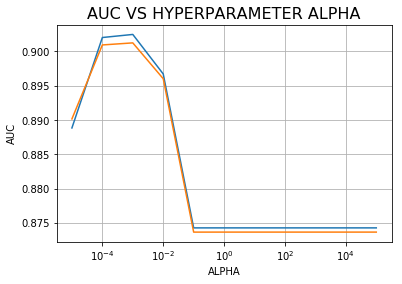



 Alpha Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each  value is :
  [0.88884 0.90203 0.90248 0.89671 0.87426 0.87426 0.87426 0.87426 0.87426
 0.87426 0.87426]

 CV AUC for each value is :
  [0.89015 0.90095 0.90125 0.89602 0.87364 0.87364 0.87364 0.87364 0.87364
 0.87364 0.87364]


In [130]:
plt.plot(alpha,train_auc_w2v)
plt.plot(alpha,cv_auc_w2v)
plt.xlabel('ALPHA',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER ALPHA',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n Alpha Values :\n", alpha)
print("\n Train AUC for each  value is :\n ", np.round(train_auc_w2v,5))
print("\n CV AUC for each value is :\n ", np.round(cv_auc_w2v,5))

In [131]:
max(cv_auc_w2v)

0.901245708012137

# Observations:

1) Optimal number of alpha= 0.001 as the cv_auc is high at that point

# Running the model with the optimal hyperparameter 

In [132]:
om_w2v = SGDClassifier(alpha=0.001,class_weight = 'balanced') # Hinge loss is not used as probabilities I cannot get
om_w2v = CalibratedClassifierCV(om_w2v, cv= 5)

In [133]:
om_w2v.fit(e5, y_train1)
ompredictions_w2v  = om_w2v.predict(f5)
probs4 = om_w2v.predict_proba(e5)
probs5 = om_w2v.predict_proba(f5)
probs4= probs4[:, 1]
probs5 = probs5[:, 1]

# PERFORMANCE MEASURMENTS FOR w2v Decision Tree

In [134]:
precision_w2v = precision_score(y_test1, ompredictions_w2v, pos_label = 1) 
recall_w2v = recall_score(y_test1, ompredictions_w2v, pos_label = 1) 
f1score_w2v = f1_score(y_test1, ompredictions_w2v, pos_label = 1) 

print('\nThe Test Precision for optimal alpha for Linear SVM (W2V) is %f' % (precision_w2v))
print('\nThe Test Recall for optimal alpha for Linear SVM (W2V) is  %f' % (recall_w2v))
print('\nThe Test F1-Score for optimal alpha for Linear SVM (W2V) is  %f' % (f1score_w2v))


The Test Precision for optimal alpha for Linear SVM (W2V) is 0.828214

The Test Recall for optimal alpha for Linear SVM (W2V) is  0.999220

The Test F1-Score for optimal alpha for Linear SVM (W2V) is  0.905716


Text(0.5, 1.0, 'Confusion Matrix\n')

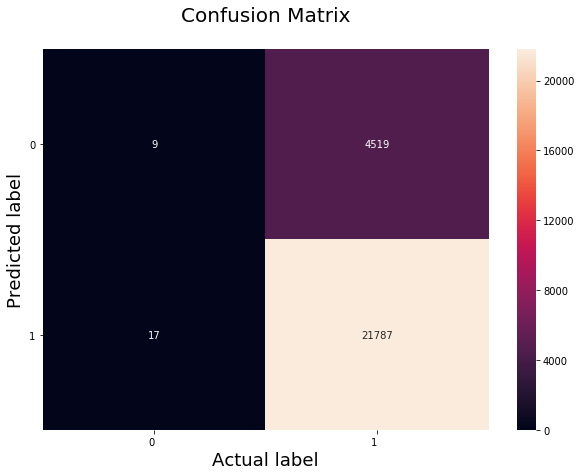

In [135]:
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2v), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [136]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2v).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of Linear SVM (W2V) for optimal alpha   is :  %f" % (TPR))
print("FPR of Linear SVM (W2V) for optimal  alpha  is :  %f" % (FPR))
print("TNR of Linear SVM (W2V) for optimal alpha  is :  %f" % (TNR))
print("FNR of Linear SVM (W2V)for optimal alpha  is :  %f" % (FNR))

TPR of Linear SVM (W2V) for optimal alpha   is :  0.828214
FPR of Linear SVM (W2V) for optimal  alpha  is :  0.653846
TNR of Linear SVM (W2V) for optimal alpha  is :  0.346154
FNR of Linear SVM (W2V)for optimal alpha  is :  0.171786


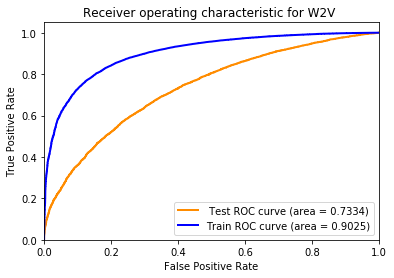

In [138]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs5)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs4)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.4f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.4f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic for W2V ')
plt.show()

# Observations :

1) Word 2 Vector Vectorizer has not performed that efficiently when compared to BOW or TFIDF vectorizer.

2) Test Acuuracy is less when compared to train accuracy. Hence Overfitting would have been the issue here.

# TFIDF AVERGE WORD TO VECTOR 

# Preparing Training Data for TFIDF-AVG W2V

In [139]:
model = TfidfVectorizer()
model.fit_transform(X_trainbow['Cleaned Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [141]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 61441/61441 [22:53<00:00, 44.73it/s]


# Preparing Test Data for TFIDF- AVG W2V

In [140]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat:
            vec = w2v_model1.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 26332/26332 [09:12<00:00, 47.63it/s]


In [142]:
g3 = tfidf_sent_vectors
h3 = tfidf_sent_vectors1

In [143]:
g3 = preprocessing.normalize(g3)
h3 = preprocessing.normalize(h3)

# LINEAR SVM  ON TFIDF - AVG W2V 

In [144]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SGDClassifier(loss='hinge',class_weight = 'balanced')
param_grid = {'alpha':alpha}
model_w2vtfidf = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 10, return_train_score = True,verbose = 3)
model_w2vtfidf.fit(g3, y_train1)
print(model_w2vtfidf.best_estimator_)
print(model_w2vtfidf.score(h3, y_test1))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8817886935493994, total=   0.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8592748146380289, total=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.858845065096062, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8694773732500823, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8681442693540173, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8561050155720541, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............. alpha=1e-05, score=0.863829514770191, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8544730763035655, total=   0.1s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.8629394588904432, total=   0.1s
[CV] a

[CV] ................ alpha=1, score=0.8251524484817191, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8563573149568431, total=   0.0s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8515235320855006, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8581986418315406, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8606165593013635, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8548734576763274, total=   0.1s
[CV] alpha=10 ........................................................
[CV] ............... alpha=10, score=0.8268897810708251, total=   0.1s
[CV] alpha=10 ........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:   22.1s finished


SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
0.7001261499818816


In [153]:
train_auc1 = model_w2vtfidf.cv_results_['mean_train_score']
cv_auc1 = model_w2vtfidf.cv_results_['mean_test_score']

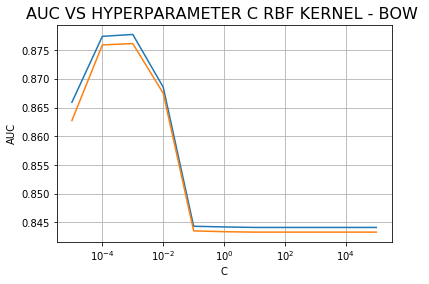



 C Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each c value is :
  [0.86592 0.8774  0.87773 0.86855 0.84434 0.84423 0.84414 0.84414 0.84414
 0.84414 0.84414]

 CV AUC for each c value is :
  [0.86274 0.8759  0.87614 0.86749 0.84354 0.8434  0.84333 0.84333 0.84333
 0.84333 0.84333]


In [154]:
plt.plot(alpha,train_auc1)
plt.plot(alpha,cv_auc1)
plt.xlabel('C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER C RBF KERNEL - BOW ',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n C Values :\n", alpha)
print("\n Train AUC for each c value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each c value is :\n ", np.round(cv_auc1,5))

In [155]:
max(cv_auc1)

0.8761383064366894

# Running the model with the optimal Alpha for TFIDF AVGW2V - Li SVM

In [156]:
om_w2vtfidf = SGDClassifier(alpha=0.001,class_weight = 'balanced') # Hinge loss is not used as probabilities I cannot get
om_w2vtfidf = CalibratedClassifierCV(om_w2vtfidf, cv= 5)

In [157]:
om_w2vtfidf.fit(g3, y_train1)
ompredictions_w2vtfidf  = om_w2vtfidf.predict(h3)

In [158]:
probs6 = om_w2vtfidf.predict_proba(g3)
probs7 = om_w2vtfidf.predict_proba(h3)
probs6= probs6[:, 1]
probs7 = probs7[:, 1]

In [159]:
precision_w2vtfidf = precision_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
recall_w2vtfidf = recall_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 
f1score_w2vtfidf = f1_score(y_test1, ompredictions_w2vtfidf, pos_label = 1) 

In [160]:
print('\nThe Test Precision FOR LINEAR SVM  (TFIDF AVGW2V) is %f' % (precision_w2vtfidf))
print('\nThe Test Recall FOR LINEAR SVM  (TFIDF AVGW2V) is  %f' % (recall_w2vtfidf))
print('\nThe Test F1-Score FOR LINEAR SVM  (TFIDF AVGW2V) is  %f' % (f1score_w2vtfidf))


The Test Precision FOR LINEAR SVM  (TFIDF AVGW2V) is 0.828270

The Test Recall FOR LINEAR SVM  (TFIDF AVGW2V) is  0.997844

The Test F1-Score FOR LINEAR SVM  (TFIDF AVGW2V) is  0.905184


Text(0.5, 1.0, 'Confusion Matrix\n')

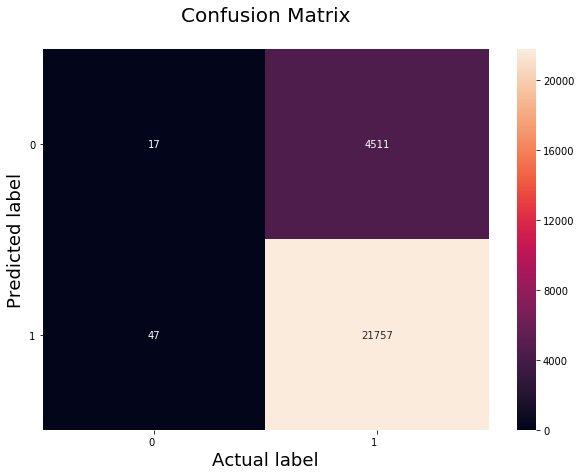

In [161]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test1, ompredictions_w2vtfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [162]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test1, ompredictions_w2vtfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the Linear SVM  (TFIDF AVG W2V) for alpha  is :  %f" % (TPR))
print("FPR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  %f" % (FPR))
print("TNR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  %f" % (TNR))
print("FNR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  %f" % (FNR))

TPR of the Linear SVM  (TFIDF AVG W2V) for alpha  is :  0.828270
FPR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  0.734375
TNR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  0.265625
FNR of the Linear SVM (TFIDF AVGW2V) for alpha  is :  0.171730


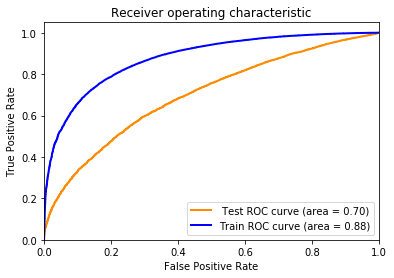

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test1,probs7)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train1,probs6)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Observations 

1) Both Training Accuracy and Test acccuracy has been not that high in TFIDF- AVG W2V. 
  The reason might be the case that I did not take feature engineering for this vectoriser and the model may be over fitted.


# Preparing the Data for RBF Kernel 

In [164]:
sample1.head(5)

,Cleaned Text,Length
0,dogs loves chicken product china wont buying a...,162
1,dogs love saw pet store tag attached regarding...,72
2,infestation fruitflies literally everywhere fl...,406
3,worst product gotten long time would rate no s...,209
4,wish would read reviews making purchase basica...,277


In [165]:
X= sample1
y= np.array(final['Score'])
X= X[:20000]
y= y[:20000]

In [166]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X,y,test_size=0.3,shuffle=False)

# BOW DATA FOR RBF KERNEL 

In [167]:
count_vect = CountVectorizer(min_df=10,max_features=500) 
a1_rbf = count_vect.fit_transform(X_train2['Cleaned Text'].values)
b1_rbf = count_vect.transform(X_test2['Cleaned Text'])

In [168]:
a1_rbf = preprocessing.normalize(a1_rbf)
a2_rbf = sparse.csr_matrix(X_train2['Length'].values)
a2_rbf = preprocessing.normalize(a2_rbf)
a3_rbf = sparse.hstack([a1_rbf, a2_rbf.T])

In [169]:
b1_rbf = preprocessing.normalize(b1_rbf)
b2_rbf = sparse.csr_matrix(X_test2['Length'].values)
b2_rbf = preprocessing.normalize(b2_rbf)
b3_rbf = sparse.hstack([b1_rbf, b2_rbf.T])

# Preparing TFIDF DATA  FOR RBF KERNEL

In [170]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=500)
c1_rbf = tf_idf_vect.fit_transform(X_train2['Cleaned Text'].values)
d1_rbf = tf_idf_vect.transform(X_test2['Cleaned Text'])
print("the type of count vectorizer :",type(c1_rbf))
print("the shape of out text TFIDF vectorizer : ",c1_rbf.get_shape())
print("the number of unique words :", c1_rbf.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (14000, 500)
the number of unique words : 500


In [171]:
c1_rbf = preprocessing.normalize(c1_rbf)
c2_rbf = sparse.csr_matrix(X_train2['Length'].values)
c2_rbf = preprocessing.normalize(c2_rbf)
c3_rbf = sparse.hstack([c1_rbf, c2_rbf.T])

In [172]:
d1_rbf = preprocessing.normalize(d1_rbf)
d2_rbf = sparse.csr_matrix(X_test2['Length'].values)
d2_rbf = preprocessing.normalize(d2_rbf)
d3_rbf = sparse.hstack([d1_rbf, d2_rbf.T])

# PREPARING W2V DATA FOR RBF KERNEL 

# Training Data 

In [173]:
i=0
list_of_sentance=[]
for sentance in (X_train2['Cleaned Text'].values):
    list_of_sentance.append(sentance.split())

In [174]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('good', 0.8201214671134949), ('excellent', 0.7648059725761414), ('perfect', 0.7574174404144287), ('amazing', 0.7486943006515503), ('fantastic', 0.7406551241874695), ('wonderful', 0.7186780571937561), ('well', 0.7147866487503052), ('love', 0.7107311487197876), ('delicious', 0.7041605114936829), ('tasty', 0.6969573497772217)]
[('leonidas', 0.9819067120552063), ('experienced', 0.9817522168159485), ('married', 0.9791007041931152), ('tipped', 0.9762768745422363), ('shared', 0.9755205512046814), ('necco', 0.9727638959884644), ('belgium', 0.9725375771522522), ('disgusting', 0.9715484380722046), ('addict', 0.9713589549064636), ('introduce', 0.9708647131919861)]
number of words that occured minimum 5 times  7154
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 's

In [175]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:15<00:00, 896.49it/s]


14000
50


# Test Data for RBF KERNEL 

In [176]:
i=0
list_of_sentance1=[]
for sentance in (X_test2['Cleaned Text'].values):
    list_of_sentance1.append(sentance.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model1=Word2Vec(list_of_sentance1,min_count=5,size=50, workers=4)
    print(w2v_model1.wv.most_similar('great'))
    print('='*50)
    print(w2v_model1.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model1.wv.most_similar('great'))
        print(w2v_model1.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

[('good', 0.9847504496574402), ('pretty', 0.9795107245445251), ('stuff', 0.9754118323326111), ('greasy', 0.9752474427223206), ('salty', 0.9749279022216797), ('crunchy', 0.9733189344406128), ('tasty', 0.9725238084793091), ('chemical', 0.9713350534439087), ('chewy', 0.9702329635620117), ('right', 0.9699370861053467)]
[('bonus', 0.9979056119918823), ('kosher', 0.9974634647369385), ('certified', 0.9974031448364258), ('kinds', 0.997395396232605), ('absolute', 0.9973660111427307), ('amy', 0.9973113536834717), ('hardly', 0.9971849918365479), ('comment', 0.9970866441726685), ('tastiest', 0.9970847368240356), ('non', 0.9970841407775879)]
number of words that occured minimum 5 times  3979
sample words  ['could', 'not', 'find', 'product', 'grocery', 'store', 'stores', 'shop', 'decided', 'check', 'amazon', 'husband', 'love', 'seasoning', 'popcorn', 'really', 'good', 'speedy', 'delivery', 'thanks', 'cheaper', 'order', 'buy', 'thru', 'local', 'charges', 'bottle', 'usually', 'weeks', 'time', 'one', '

In [177]:
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1465.97it/s]


6000
50


In [178]:
e3 = sent_vectors
f3 = sent_vectors1
e3 = preprocessing.normalize(e3)
e4 = sparse.csr_matrix(X_train2['Length'].values)
e4 = preprocessing.normalize(e4)
e5_rbf = sparse.hstack([e3, e4.T])
f3 = preprocessing.normalize(f3)
f4 = sparse.csr_matrix(X_test2['Length'].values)
f4 = preprocessing.normalize(f4)
f5_rbf = sparse.hstack([f3, f4.T])

# PREPARING TFIDF AVG W2V DATA FOR RBF KERNEL 

In [179]:
model = TfidfVectorizer(min_df=10,max_features=500)
model.fit_transform(X_train2['Cleaned Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [180]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:20<00:00, 679.28it/s]


In [181]:
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat:
            vec = w2v_model1.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1125.55it/s]


In [182]:
g3 = tfidf_sent_vectors
h3 = tfidf_sent_vectors1
g3_rbf = preprocessing.normalize(g3)
h3_rbf = preprocessing.normalize(h3)

# Grid Seach RBF KERNEL FOR ALL VECTORIZERS (BOW, TFIDF, AVGW2V, TFIDF-AVGW2V)

# BOW

In [185]:
C = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SVC()
param_grid = {'C': C}
model_bow = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 3, return_train_score = True, verbose = 3)
model_bow.fit(a3_rbf, y_train2)
print(model_bow.best_estimator_)
print(model_bow.score(b3_rbf, y_test2))

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8032958073586891, total=   7.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8021214759291662, total=   6.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.9s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.825800617236036, total=   7.2s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8032958073586891, total=   8.3s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8021214759291662, total=   7.6s
[CV] C=0.0001 ........................................................
[CV] ................ C=0.0001, score=0.825800617236036, total=   7.5s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8032304969476353, total=   7.4s
[CV] C=0.001 .........................................................
[CV] ................. C=0.001, score=0.802892641167377, total=   7.6s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8257916332462245, total=   7.7s
[CV] C

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  8.9min finished


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.8921129986638672


# TFIDF 

In [186]:
C = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SVC()
param_grid = {'C': C}
model_tfidf = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 3, return_train_score = True, verbose = 3)
model_tfidf.fit(c3_rbf, y_train2)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8388842398083463, total=   6.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8374353893433505, total=   6.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.1s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8301618052500999, total=   7.5s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8388842398083463, total=   6.5s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8374353893433505, total=   6.6s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.8301618052500999, total=   7.1s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8388842398083463, total=   7.5s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8374353893433505, total=   6.5s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.8301618052500999, total=   6.7s
[CV] C

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  8.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=3)

In [187]:
print(model_tfidf.best_estimator_)
print(model_tfidf.score(d3_rbf, y_test2))

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.8935110602108121


# AVG W2V 

In [189]:
C = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SVC()
param_grid = {'C': C}
model_w2v = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 10, return_train_score = True, verbose = 3)
model_w2v.fit(e5_rbf, y_train2)
print(model_w2v.best_estimator_)
print(model_w2v.score(f5_rbf, y_test2))

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8280576685650564, total=   6.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8183400374367757, total=   6.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.796766568744295, total=   6.6s
[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.819941087137624, total=   6.3s
[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.818274945292352, total=   6.1s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8406642245863545, total=   6.3s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8499994021022086, total=   6.7s
[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.8414873305458008, total=   6.3s
[CV] C=1e-05 .........................................................
[CV] ................. C=1e-05, score=0.783964115503224, total=   6.2s
[CV] C

[CV] ..................... C=1, score=0.830421722936441, total=   9.0s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8547054840893704, total=   8.6s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8703174160659524, total=   8.7s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8642014676397786, total=   8.7s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8520681284603335, total=   8.6s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8578119332427185, total=   8.5s
[CV] C=10 ............................................................
[CV] ................... C=10, score=0.8778773831209468, total=   8.5s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed: 43.5min finished


SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.5392036224046151


# TFIDF - AVGW2V

In [190]:
C = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = SVC()
param_grid = {'C': C}
model_w2vtfidf = GridSearchCV(estimator = clf,param_grid=param_grid ,scoring = 'roc_auc',cv = 3, return_train_score = True, verbose = 3)
model_w2vtfidf.fit(g3_rbf, y_train2)
print(model_w2vtfidf.best_estimator_)
print(model_w2vtfidf.score(h3_rbf, y_test2))

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.7526617580988499, total=   2.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.7900130333743378, total=   2.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] C=1e-05 .........................................................
[CV] ................ C=1e-05, score=0.7627116268639982, total=   2.3s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.7526617580988499, total=   2.3s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.7900130333743378, total=   2.3s
[CV] C=0.0001 ........................................................
[CV] ............... C=0.0001, score=0.7627116268639982, total=   2.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7565183019867284, total=   2.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7927453051862208, total=   2.3s
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.7657428250263769, total=   2.3s
[CV] C

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:  4.8min finished


SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.5555977603868423


# Observations:

1) We observe that the optimal c is 100 for both BOW and  TFIDF vectorizers.  

2) However Optimal C is 100000 for W2V and 100000 for tfidf- avgw2v.

3) TFIDF performed slightly better when compared to BOW. However TFIDF AVGW2V efficiency was the least. 

3) Now let us check whether these corresponding optimal hyperparameters are the actual ones by plotting grahs.

# BOW 

In [191]:
alpha = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]

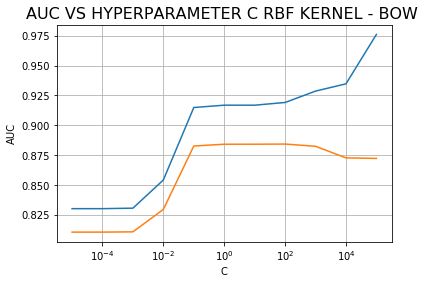



 C Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each c value is :
  [0.83006 0.83006 0.83048 0.85409 0.91481 0.91677 0.91677 0.91903 0.92857
 0.93465 0.97605]

 CV AUC for each c value is :
  [0.8104  0.8104  0.81064 0.82941 0.88255 0.88406 0.88407 0.88418 0.88234
 0.87261 0.87216]


In [192]:
train_auc1= model_bow.cv_results_['mean_train_score']
cv_auc1= model_bow.cv_results_['mean_test_score']
plt.plot(alpha,train_auc1)
plt.plot(alpha,cv_auc1)
plt.xlabel('C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER C RBF KERNEL - BOW ',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n C Values :\n", alpha)
print("\n Train AUC for each c value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each c value is :\n ", np.round(cv_auc1,5))

In [193]:
max(cv_auc1)

0.8841795644455238

In [ ]:
# We found that the optimal C is 100 

In [ ]:
# Running the model with optimal C

In [194]:
om_bow = SVC(C=100, probability = True)
om_bow.fit(a3_rbf, y_train2)
ompredictions_bow  = om_bow.predict(b3_rbf)
probs = om_bow.predict_proba(b3_rbf)
probs1 = om_bow.predict_proba(a3_rbf)
probs = probs[:, 1]
probs1 = probs1[:, -1]

# PERFORMANCE METRICS  - RBF KERNEL - BOW 

In [196]:
precision_bow = precision_score(y_test2, ompredictions_bow, pos_label = 1) 
recall_bow = recall_score(y_test2, ompredictions_bow, pos_label = 1) 
f1score_bow = f1_score(y_test2, ompredictions_bow, pos_label = 1) 
print('\nThe Test Precision for OPTIMAL C for RBF KERNEL (BOW)   is %f' % (precision_bow))
print('\nThe Test Recall for  OPTIMAL C for RBF KERNEL (BOW)  is %f' % (recall_bow))
print('\nThe Test F1-Score for  OPTIMAL C for RBF KERNEL (BOW)  is %f' %  (f1score_bow))


The Test Precision for OPTIMAL C for RBF KERNEL (BOW)   is 0.883881

The Test Recall for  OPTIMAL C for RBF KERNEL (BOW)  is 0.986391

The Test F1-Score for  OPTIMAL C for RBF KERNEL (BOW)  is 0.932327


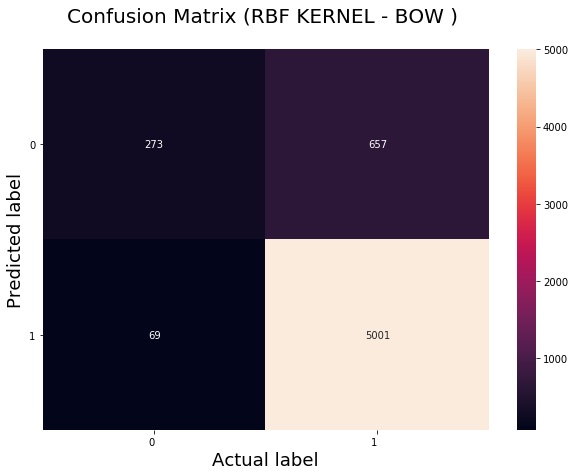

In [197]:
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test2, ompredictions_bow), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix (RBF KERNEL - BOW ) \n",size=20)
plt.show()

In [198]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test2, ompredictions_bow).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the RBF KERNEL  (BOW)   is :  %f" % (TPR))
print("FPR of the RBF KERNEL (BOW)   is :  %f" % (FPR))
print("TNR of the RBF KERNEL (BOW)   is :  %f" % (TNR))
print("FNR of the RBF KERNEL (BOW)  is :  %f" % (FNR))

TPR of the RBF KERNEL  (BOW)   is :  0.883881
FPR of the RBF KERNEL (BOW)   is :  0.201754
TNR of the RBF KERNEL (BOW)   is :  0.798246
FNR of the RBF KERNEL (BOW)  is :  0.116119


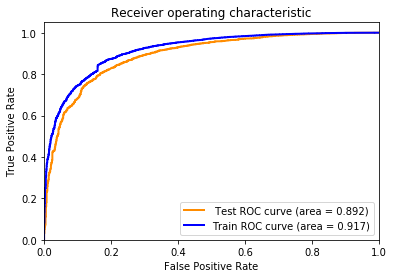

In [199]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test2,probs)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train2,probs1)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])   

#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.3f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()    

# Observations :
1) We found that the train score is 0.92 and the test score is 0.89 . 

2) This implies that the model is reasonably good.

# TFIDF 

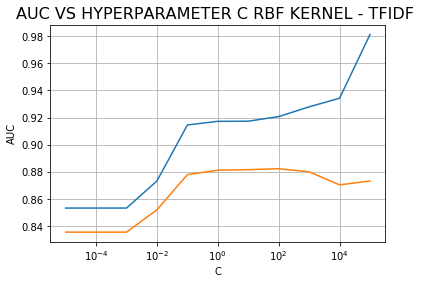



 C Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each c value is :
  [0.85324 0.85324 0.85324 0.87326 0.91452 0.91721 0.91729 0.92072 0.92789
 0.93426 0.98129]

 CV AUC for each c value is :
  [0.83549 0.83549 0.83549 0.85197 0.87793 0.88117 0.88157 0.88224 0.87996
 0.87034 0.8732 ]


In [200]:
train_auc1= model_tfidf.cv_results_['mean_train_score']
cv_auc1= model_tfidf.cv_results_['mean_test_score']
plt.plot(alpha,train_auc1)
plt.plot(alpha,cv_auc1)
plt.xlabel('C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER C RBF KERNEL - TFIDF ',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n C Values :\n", alpha)
print("\n Train AUC for each c value is :\n ", np.round(train_auc1,5))
print("\n CV AUC for each c value is :\n ", np.round(cv_auc1,5))

In [201]:
max(cv_auc1)

0.8822377980878033

In [202]:
om_tfidf = SVC(C=100, probability = True)
om_tfidf.fit(c3_rbf, y_train2)
ompredictions_tfidf  = om_tfidf.predict(d3_rbf)
probs2 = om_tfidf.predict_proba(c3_rbf)
probs3 = om_tfidf.predict_proba(d3_rbf)
probs2= probs2[:, 1]
probs3 = probs3[:, 1]

In [203]:
precision_tfidf = precision_score(y_test2, ompredictions_tfidf, pos_label = 1) 
recall_tfidf = recall_score(y_test2, ompredictions_tfidf, pos_label = 1) 
f1score_tfidf = f1_score(y_test2, ompredictions_tfidf, pos_label = 1) 
print('\nThe Test Precision for optimal C for RBF KERNEL (TFIDF)   is %f' % (precision_bow))
print('\nThe Test Recall for optimal C for RBF KERNEL (TFIDF)  is %f' % (recall_bow))
print('\nThe Test F1-Score for optimal C for RBF KERNEL (TFIDF)  is %f' %  (f1score_bow))


The Test Precision for optimal C for RBF KERNEL (TFIDF)   is 0.883881

The Test Recall for optimal C for RBF KERNEL (TFIDF)  is 0.986391

The Test F1-Score for optimal C for RBF KERNEL (TFIDF)  is 0.932327


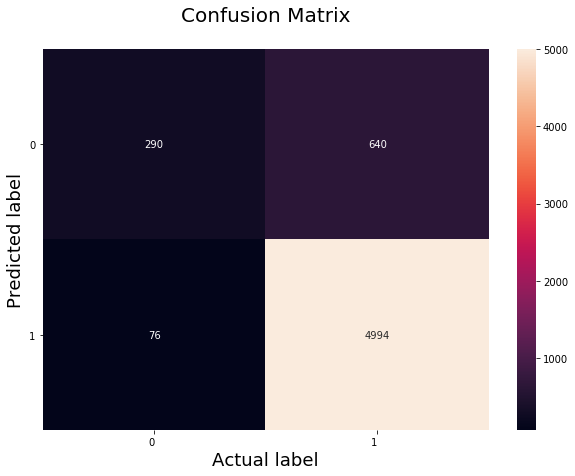

In [204]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test2, ompredictions_tfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)
plt.show()


In [205]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test2, ompredictions_tfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C   is :  %f" % (TPR))
print("FPR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C:  %f" % (FPR))
print("TNR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C :  %f" % (TNR))
print("FNR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C :  %f" % (FNR))

TPR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C   is :  0.886404
FPR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C:  0.207650
TNR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C :  0.792350
FNR of the SVM - RBF KERNEL (TFIDF) for OPTIMAL C :  0.113596


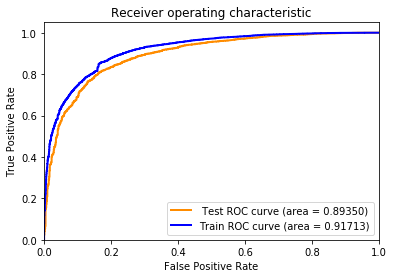

In [206]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test2,probs3)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train2,probs2)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])   

#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.5f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.5f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()   

# Observations :
1) We found that train auc is 0.91713 and test auc is 0.89350. This also imples that model is reasonably good.  

# W2V AVG

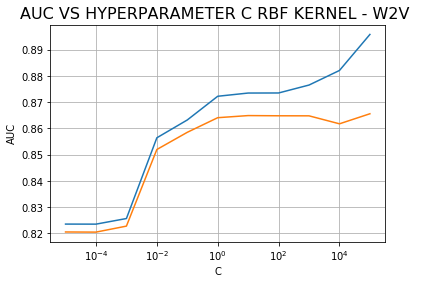



 C Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each c value is :
  [0.82358 0.82356 0.82569 0.85645 0.86324 0.87227 0.8735  0.87353 0.87655
 0.8821  0.89583]

 CV AUC for each c value is :
  [0.82057 0.82052 0.82281 0.85199 0.85854 0.86411 0.86491 0.86484 0.86482
 0.86178 0.86561]


In [207]:
train_auc_w2v1= model_w2v.cv_results_['mean_train_score']
cv_auc_w2v1= model_w2v.cv_results_['mean_test_score']
plt.plot(alpha,train_auc_w2v1)
plt.plot(alpha,cv_auc_w2v1)
plt.xlabel('C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER C RBF KERNEL - W2V ',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n C Values :\n", alpha)
print("\n Train AUC for each c value is :\n ", np.round(train_auc_w2v1,5))
print("\n CV AUC for each c value is :\n ", np.round(cv_auc_w2v1,5))

In [208]:
max(cv_auc_w2v1)

0.8656071265247317

In [209]:
om_w2v = SVC(C=100000, probability = True)
om_w2v.fit(e5_rbf, y_train2)
ompredictions_w2v  = om_w2v.predict(f5_rbf)
probs4 = om_w2v.predict_proba(e5_rbf)
probs5 = om_w2v.predict_proba(f5_rbf)
probs4= probs4[:, 1]
probs5 = probs5[:, 1]


The Test Precision for optimal c for RBF - KERNEL - SVM (W2V) is 0.893891

The Test Recall for optimal c for RBF - KERNEL - SVM (W2V) is  0.054832

The Test F1-Score for optimal c for RBF - KERNEL - SVM (W2V) is  0.103327


Text(0.5, 1.0, 'Confusion Matrix\n')

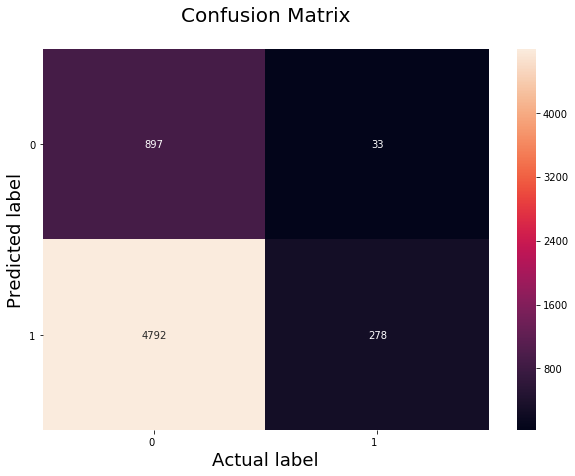

In [210]:
precision_w2v = precision_score(y_test2, ompredictions_w2v, pos_label = 1) 
recall_w2v = recall_score(y_test2, ompredictions_w2v, pos_label = 1) 
f1score_w2v = f1_score(y_test2, ompredictions_w2v, pos_label = 1) 

print('\nThe Test Precision for optimal c for RBF - KERNEL - SVM (W2V) is %f' % (precision_w2v))
print('\nThe Test Recall for optimal c for RBF - KERNEL - SVM (W2V) is  %f' % (recall_w2v))
print('\nThe Test F1-Score for optimal c for RBF - KERNEL - SVM (W2V) is  %f' % (f1score_w2v))

class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test2, ompredictions_w2v), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

In [211]:
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test2, ompredictions_w2v).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the SVM - RBF KERNEL (W2V) for OPTIMAL C   is :  %f" % (TPR))
print("FPR of the SVM - RBF KERNEL (W2V) for OPTIMAL C:  %f" % (FPR))
print("TNR of the SVM - RBF KERNEL (W2V) for OPTIMAL C :  %f" % (TNR))
print("FNR of the SVM - RBF KERNEL (W2V) for OPTIMAL C :  %f" % (FNR))

TPR of the SVM - RBF KERNEL (W2V) for OPTIMAL C   is :  0.893891
FPR of the SVM - RBF KERNEL (W2V) for OPTIMAL C:  0.842327
TNR of the SVM - RBF KERNEL (W2V) for OPTIMAL C :  0.157673
FNR of the SVM - RBF KERNEL (W2V) for OPTIMAL C :  0.106109


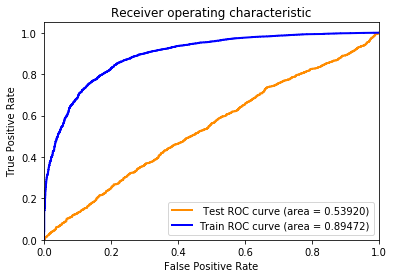

In [212]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

#for i in range(26331):
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test2,probs5)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#for i in range(61441):
for i in range(4):    
    fpr1[i], tpr1[i], _ = roc_curve(y_train2,probs4)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])   

#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.5f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.5f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()  

# Observations :

1) Even though the training score is high (0.8947) , the test score has been very less (0.5392)

2) This implies that the model has not been that efficient

# TFIDF AVG W2V 

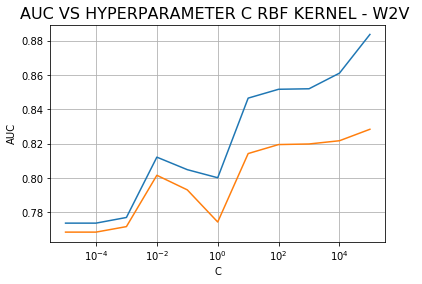



 C Values :
 [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

 Train AUC for each c value is :
  [0.7737  0.7737  0.777   0.81216 0.80487 0.80015 0.84657 0.85173 0.85202
 0.86113 0.88369]

 CV AUC for each c value is :
  [0.76846 0.76846 0.77167 0.80159 0.79309 0.77435 0.81426 0.8195  0.81984
 0.82173 0.82841]


In [213]:
train_auc_w2v1= model_w2vtfidf.cv_results_['mean_train_score']
cv_auc_w2v1=model_w2vtfidf.cv_results_['mean_test_score']
plt.plot(alpha,train_auc_w2v1)
plt.plot(alpha,cv_auc_w2v1)
plt.xlabel('C',size=10)
plt.ylabel('AUC',size=10)
plt.title('AUC VS HYPERPARAMETER C RBF KERNEL - W2V ',size=16)
plt.xscale('log')
plt.grid()
plt.show()
print("\n\n C Values :\n", alpha)
print("\n Train AUC for each c value is :\n ", np.round(train_auc_w2v1,5))
print("\n CV AUC for each c value is :\n ", np.round(cv_auc_w2v1,5))

In [214]:
max(cv_auc_w2v1) # Hence Optimal C = 100000

0.828411680589382

In [215]:
om_w2vtfidf = SVC(C=100000, probability = True)

In [216]:
om_w2vtfidf.fit(g3_rbf, y_train2)
ompredictions_w2vtfidf  = om_w2vtfidf.predict(h3_rbf)
probs6 = om_w2vtfidf.predict_proba(g3_rbf)
probs7 = om_w2vtfidf.predict_proba(h3_rbf)
probs6= probs6[:, 1]
probs7 = probs7[:, 1]
precision_w2vtfidf = precision_score(y_test2, ompredictions_w2vtfidf, pos_label = 1) 
recall_w2vtfidf = recall_score(y_test2, ompredictions_w2vtfidf, pos_label = 1) 
f1score_w2vtfidf = f1_score(y_test2, ompredictions_w2vtfidf, pos_label = 1) 
print('\nThe Test Precision FOR RBF KERNEL SVM  (TFIDF AVGW2V) is %f' % (precision_w2vtfidf))
print('\nThe Test Recall FOR RBF KERNEL SVM  (TFIDF AVGW2V) is  %f' % (recall_w2vtfidf))
print('\nThe Test F1-Score FOR RBF KERNEL SVM  (TFIDF AVGW2V) is  %f' % (f1score_w2vtfidf))
TrueNeg,FalseNeg,FalsePos, TruePos = confusion_matrix(y_test2, ompredictions_w2vtfidf).ravel()
TPR = TruePos/(FalseNeg + TruePos)
FPR = FalsePos/(TrueNeg + FalsePos)
TNR = TrueNeg/(TrueNeg + FalsePos)
FNR = FalseNeg/(FalseNeg + TruePos)
print("TPR of the RBF KERNEL SVM  (TFIDF AVG W2V) for alpha  is :  %f" % (TPR))
print("FPR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  %f" % (FPR))
print("TNR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  %f" % (TNR))
print("FNR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  %f" % (FNR))


The Test Precision FOR RBF KERNEL SVM  (TFIDF AVGW2V) is 0.869307

The Test Recall FOR RBF KERNEL SVM  (TFIDF AVGW2V) is  0.173176

The Test F1-Score FOR RBF KERNEL SVM  (TFIDF AVGW2V) is  0.288816
TPR of the RBF KERNEL SVM  (TFIDF AVG W2V) for alpha  is :  0.869307
FPR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  0.840080
TNR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  0.159920
FNR of the RBF KERNEL SVM (TFIDF AVGW2V) for alpha  is :  0.130693


Text(0.5, 1.0, 'Confusion Matrix\n')

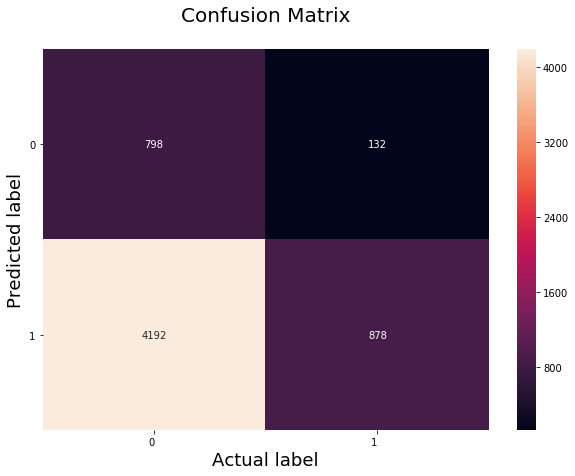

In [217]:
# Code for drawing seaborn heatmaps
class_names = [ 0,1]
df_heatmap = pd.DataFrame(confusion_matrix(y_test2, ompredictions_w2vtfidf), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)#
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
plt.ylabel('Predicted label',size=18)
plt.xlabel('Actual label',size=18)
plt.title("Confusion Matrix\n",size=20)

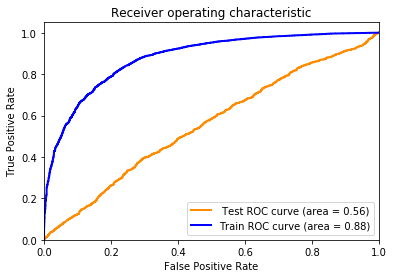

In [218]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test2,probs7)
    roc_auc[i] = auc(fpr[i], tpr[i])


from tqdm import tqdm
for i in range(4):
    fpr1[i], tpr1[i], _ = roc_curve(y_train2,probs6)
    roc_auc1[i] = auc(fpr1[i], tpr1[i])    


#print(roc_auc_score(y_test1,ompredictions_bow))
plt.figure()
#plt.plot(fpr[1], tpr[1])
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label=' Test ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot(fpr1[0], tpr1[0], color='blue',lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc1[0])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic')
plt.show()

# Conclusions

In [225]:
res = pd.DataFrame()

In [226]:
model_names = ["Linear - KERNEL  SVM" , "Linear - KERNEL  SVM" ,"Linear - KERNEL  SVM" ,"Linear - KERNEL  SVM" ,"RBF - KERNEL SVM ","RBF - KERNEL SVM ","RBF - KERNEL SVM ","RBF - KERNEL SVM "]
vectorizer = ["BOW","TFIDF","AVG W2V","TFIDF AVGW2V"]*2
test_AUC = [0.946,0.9497,0.7334,0.70,0.892,0.8935,0.5392,0.56 ]
train_AUC = [0.958,0.9672,0.9025,0.88,0.917,0.917,0.8947, 0.88]
hyperparameter = ["alpha","alpha","alpha","alpha","C","C","C","C"]
Value = [0.0001,0.0001,0.001,0.001,100,100,100000,100000]

In [227]:
res['Vectorizer'] = vectorizer
res['Model '] = model_names
res['Hyperparameter'] = hyperparameter  
res['Value'] = Value
res['Train_AUC'] = train_AUC
res['Test_AUC'] = test_AUC

In [228]:
res

,Vectorizer,Model,Hyperparameter,Value,Train_AUC,Test_AUC
0,BOW,Linear - KERNEL SVM,alpha,0.0001,0.9580,0.9460
1,TFIDF,Linear - KERNEL SVM,alpha,0.0001,0.9672,0.9497
2,AVG W2V,Linear - KERNEL SVM,alpha,0.0010,0.9025,0.7334
3,TFIDF AVGW2V,Linear - KERNEL SVM,alpha,0.0010,0.8800,0.7000
4,BOW,RBF - KERNEL SVM,C,100.0000,0.9170,0.8920
5,TFIDF,RBF - KERNEL SVM,C,100.0000,0.9170,0.8935
6,AVG W2V,RBF - KERNEL SVM,C,100000.0000,0.8947,0.5392
7,TFIDF AVGW2V,RBF - KERNEL SVM,C,100000.0000,0.8800,0.5600


In [229]:
import tabulatehelper as th

# DISPLAYING THE RESULTS IN TABULAR FORMAT 

In [230]:
print(th.md_table(res, formats={-1: 'c'}))

| Vectorizer   | Model                | Hyperparameter   |       Value |   Train_AUC |   Test_AUC |
|:-------------|:---------------------|:-----------------|------------:|------------:|:----------:|
| BOW          | Linear - KERNEL  SVM | alpha            |      0.0001 |      0.958  |     0.946  |
| TFIDF        | Linear - KERNEL  SVM | alpha            |      0.0001 |      0.9672 |     0.9497 |
| AVG W2V      | Linear - KERNEL  SVM | alpha            |      0.001  |      0.9025 |     0.7334 |
| TFIDF AVGW2V | Linear - KERNEL  SVM | alpha            |      0.001  |      0.88   |     0.7    |
| BOW          | RBF - KERNEL SVM     | C                |    100      |      0.917  |     0.892  |
| TFIDF        | RBF - KERNEL SVM     | C                |    100      |      0.917  |     0.8935 |
| AVG W2V      | RBF - KERNEL SVM     | C                | 100000      |      0.8947 |     0.5392 |
| TFIDF AVGW2V | RBF - KERNEL SVM     | C                | 100000      |      0.88   |     0.56   |


# Final Observations :


1) The best models have come through BOW and TFIDF. In TFIDF the test AUC has been slightly better when compared to BOW.

2) IN THE CASE OF Linear Kernel , among AVG W2V and TFIDF AVG W2V the AVG W2V has performed marginally better. However in the scenario of RBF- Kernel   TFIDF AVG W2V  has performed marginally better when compared to AVG W2V.

3) The important observation that has to be made is in the case of AVG W2V the test AUC has been 0.73 in Linear SVM. It has dropped to 0.54 in the case of RBF KERNEL SVM. The same is the case with TFIDF AVG W2V vectorizer too. 

4) IN THE CASE OF TFIDF- AVG W2V, I HAVE NOT USED FEATURE ENGINEERING. Linear SVM performed better than the other one. 

5) As suggested I have added length of preprocessed reviews as one more feature which has been contributed for more accuracy. 
   However if i would have used more features like length of common words or something else, the results would have been 
   different( my assumption)

6) In an overall perspective Linear Kernel performed better than RBF kernel in every vectoriser. However the point that needs to be noted is as I have taken few points for RBF kernel.  

In [232]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
tree_para = [{'max_depth':[1,5,10,50,100,500,1000],'n_estimators' : [5, 10, 100, 500]}]
gbc =  GradientBoostingClassifier()
model_tfidf2 = GridSearchCV(gbc, tree_para, scoring = 'roc_auc', cv= 3, return_train_score= True,verbose = 3)
model_tfidf2.fit(c3, y_train1)
print(model_tfidf2.best_estimator_)
print(model_tfidf2.score(d3, y_test1))

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] max_depth=1, n_estimators=5 .....................................
[CV]  max_depth=1, n_estimators=5, score=0.6869598224261829, total=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV]  max_depth=1, n_estimators=5, score=0.699866606864799, total=   0.9s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] max_depth=1, n_estimators=5 .....................................
[CV]  max_depth=1, n_estimators=5, score=0.6765706579866755, total=   1.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV]  max_depth=1, n_estimators=10, score=0.7127227273655146, total=   1.9s
[CV] max_depth=1, n_estimators=10 ....................................
[CV]  max_depth=1, n_estimators=10, score=0.7198467304722067, total=   2.0s
[CV] max_depth=1, n_estimators=10 ....................................
[CV]  max_depth=1, n_estimators=10, score=0.7092088083354826, total=   1.9s
[CV] max_depth=1, n_estimators=100 ...................................
[CV]  max_depth=1, n_estimators=100, score=0.817894600072069, total=  20.4s
[CV] max_depth=1, n_estimators=100 ...................................
[CV]  max_depth=1, n_estimators=100, score=0.8333158513195863, total=  18.6s
[CV] max_depth=1, n_estimators=100 ...................................
[CV]  max_depth=1, n_estimators=100, score=0.82

# References 

I have referred many links. However part of my code has been inspired from the following links 

1) Applied AI Course 

2) SKLEARN 

3) STACK OVERFLOW  - MANY 